In [1]:
# Plots for celldancer

from matplotlib.colors import Colormap
from matplotlib.pyplot import title
import pandas as pd
from pandas.core.frame import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import scvelo as scv

#### backup of gene, celltype ####
gene_plot_l_28_alphabet=['Abcc8', 'Actn4', 'Adk', 'Ank', 'Anxa4', 
                    'Btbd17', 'Cdk1', 'Cpe', 'Dcdc2a', 'Gnao1', 
                    'Gng12', 'Map1b', 'Mapre3', 'Nfib', 'Nnat', 
                    'Pak3', 'Pcsk2', 'Pim2', 'Ppp3ca', 'Rap1b', 
                    'Rbfox3', 'Smoc1', 'Sulf2', 'Tcp11', 'Tmem163', 
                    'Top2a', 'Tspan7', 'Wfdc15b'] #28 alphabet order
gene_plot_l_28=["Ank","Abcc8","Tcp11","Nfib","Ppp3ca",# 28 genes after did the re_clustering
            "Rbfox3","Cdk1","Gng12","Map1b","Cpe",
            "Gnao1","Pcsk2","Tmem163","Pak3","Wfdc15b",
            "Nnat","Anxa4","Actn4","Btbd17","Dcdc2a",
            "Adk","Smoc1","Mapre3","Pim2","Tspan7",
            "Top2a","Rap1b","Sulf2"]
gene_plot_l_3=["Wfdc15b","Abcc8","Sulf2"] # 3 picked sample genes
adata = scv.datasets.pancreas()
gene_plot_l_all=adata.var_names # TO DO: If we output the heatmap, there contains some NAN when we check the nalist in the heatmap function. This problem needs to be figured out later.
cell_type_5=["Ductal",
            "Ngn3 low EP",
            "Ngn3 high EP",
            "Pre-endocrine",
            "Endocrine"]
cell_type=["Ductal",
            "Ngn3 low EP",
            "Ngn3 high EP",
            "Pre-endocrine",
            "Alpha",
            "Beta",
            "Delta",
            "Epsilon"]
list_e=[0,5,10,50,100,200,210,225,250,275,300,400,500,1000]



In [2]:

#### Heatmap for alpha/ expression/ others ####
# TO DO: Add the info of each cell
list_e=[500]
para="alpha_new"
savepath_para_heat="output/heatmap/alpha_allcell/alpha_e"
para="s0" #=exp
savepath_para_heat="output/heatmap/exp_allcell/exp_e"
cell_type=cell_type
g_list=gene_plot_l_28

def heatmap(data,para,detail,cell_type,g_list):
    
    detail["alpha_new"]=detail["alpha"]/detail["beta"]
    detail["beta_new"]=detail["beta"]/detail["beta"]
    detail["gamma_new"]=detail["gamma"]/detail["beta"]
    celllist_rep=pd.concat([data.obs.clusters]*len(g_list), ignore_index=True)
    detail = pd.concat([detail, celllist_rep], axis=1)
    detail_para=detail.loc[:,["gene_name",para,"clusters"]]
    detail_para_sorted = detail_para.sort_values(["clusters", "gene_name"], ascending = (False, True))

    fin_matrix=pd.DataFrame()
    for ct in cell_type:
        df = list()
        for g in g_list:
            df_v3=detail_para_sorted[(detail_para_sorted.clusters==ct) & (detail_para_sorted.gene_name==g)]
            df.append(df_v3[para])
        reshaped_array = np.reshape(df, (len(g_list),len(df_v3)))
        reshaped_array_pd = pd.DataFrame(reshaped_array)
        fin_matrix=pd.concat([fin_matrix,reshaped_array_pd],axis=1)
    fin_matrix=pd.concat([pd.DataFrame({'col':g_list}),fin_matrix],axis=1)
    return(fin_matrix)


In [4]:
import numpy as np


In [6]:
adata = scv.datasets.pancreas()
for e_num in list_e:
    file_path="output/detailcsv/adj_e/detail_e"+str(e_num)+".csv"
    detail = pd.read_csv (file_path,index_col=False)
    heat=heatmap(adata,para,detail,cell_type,g_list)
    heat.to_csv(savepath_para_heat+str(e_num)+".csv",index=False)


In [7]:

#### Velocity ####
# TO DO: modify the code to a diff style!!!!!!!!!!
# TO DO: build Class
# ref: https://github.com/velocyto-team/velocyto-notebooks/blob/master/python/DentateGyrus.ipynb
import numpy as np
from sklearn.neighbors import NearestNeighbors
def sampling_neighbors(embedding,step_i=20,step_j=20):
    from scipy.stats import norm
    def gaussian_kernel(X, mu = 0, sigma=1):
        return np.exp(-(X - mu)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)
    steps = step_i, step_j
    grs = []
    for dim_i in range(embedding.shape[1]-3):
        m, M = np.min(embedding[:, dim_i]), np.max(embedding[:, dim_i])
        m = m - 0.025 * np.abs(M - m)
        M = M + 0.025 * np.abs(M - m)
        gr = np.linspace(m, M, steps[dim_i])
        grs.append(gr)

    meshes_tuple = np.meshgrid(*grs)
    gridpoints_coordinates = np.vstack([i.flat for i in meshes_tuple]).T
    gridpoints_coordinates = gridpoints_coordinates + norm.rvs(loc=0, scale=0.15, size=gridpoints_coordinates.shape)
    
    np.random.seed(10) # set random seed
    nn = NearestNeighbors()
    nn.fit(embedding[:,0:2])
    dist, ixs = nn.kneighbors(gridpoints_coordinates, 20)
    ix_choice = ixs[:,0].flat[:]
    ix_choice = np.unique(ix_choice)

    nn = NearestNeighbors()
    nn.fit(embedding[:,0:2])
    dist, ixs = nn.kneighbors(embedding[ix_choice, 0:2], 20)
    density_extimate = gaussian_kernel(dist, mu=0, sigma=0.5).sum(1)
    bool_density = density_extimate > np.percentile(density_extimate, 25)
    ix_choice = ix_choice[bool_density]
    return(embedding[ix_choice,0:4])

def velocity_plot(detail,genelist,detail_i,color_scatter,point_size,alpha_inside,colormap,v_min,v_max,save_path):
    plt.figure(None,(6,6))
    embedding= np.array(detail[detail['gene_name'].isin(genelist)][["u0","s0","u1","s1", 'true_cost']])


    sampled_coordinates=sampling_neighbors(embedding) # Sampling

    layer1=plt.scatter(embedding[:, 1], embedding[:, 0],
                alpha=alpha_inside, s=point_size, edgecolor="none",c=detail[detail['gene_name'].isin(genelist)].alpha_new, cmap=colormap,vmin=v_min,vmax=v_max)
    plt.colorbar(layer1)
    plt.scatter(sampled_coordinates[:, 1], sampled_coordinates[:, 0],
                color="none",s=point_size, edgecolor="k")
    
    pcm1 = plt.quiver(
    sampled_coordinates[:, 1], sampled_coordinates[:, 0], sampled_coordinates[:, 3]-sampled_coordinates[:, 1], sampled_coordinates[:, 2]-sampled_coordinates[:, 0],
    angles='xy', clim=(0., 1.))
    plt.savefig(save_path)


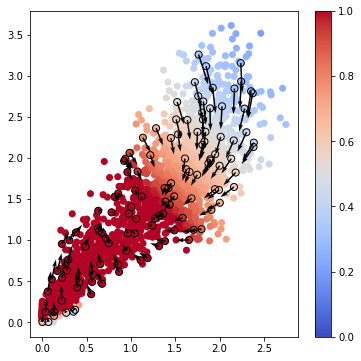

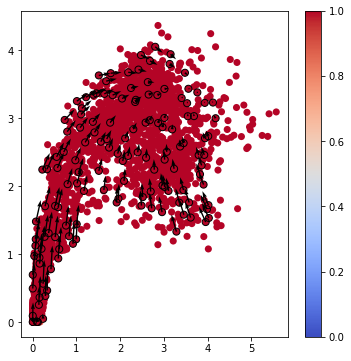

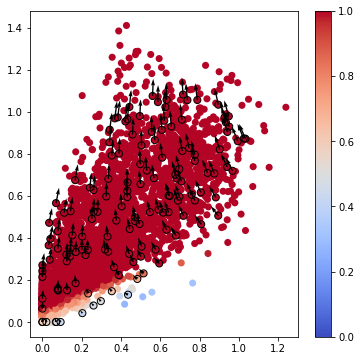

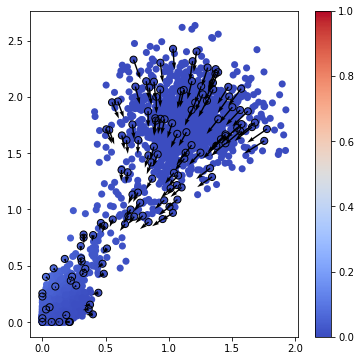

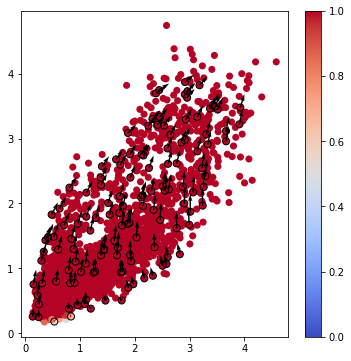

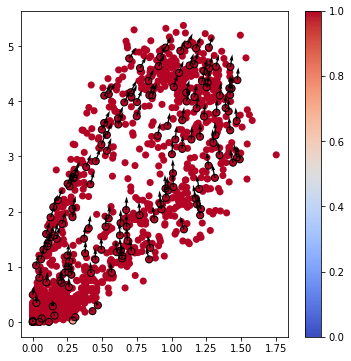

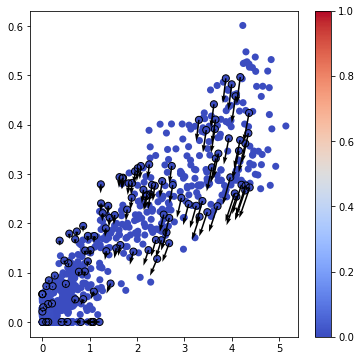

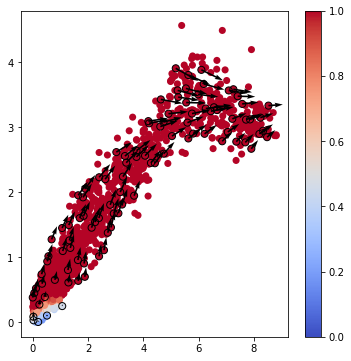

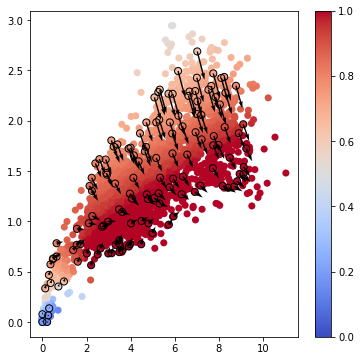

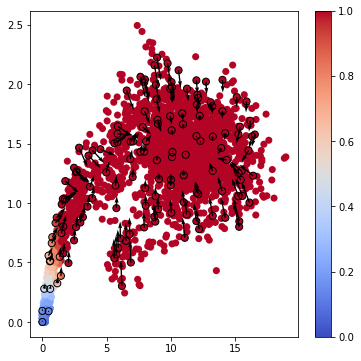

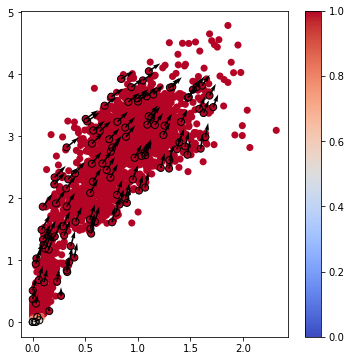

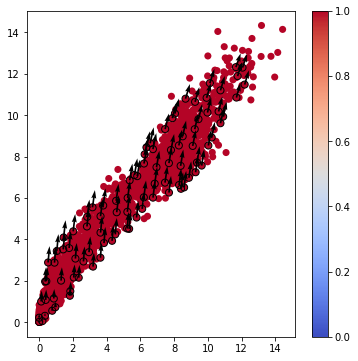

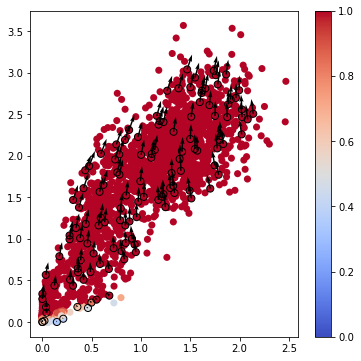

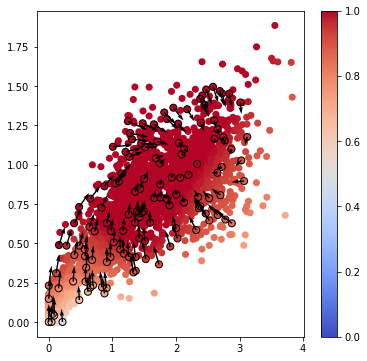

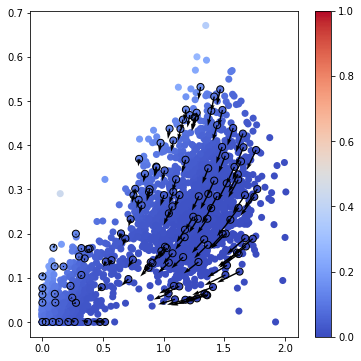

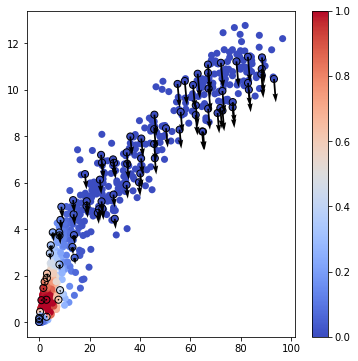

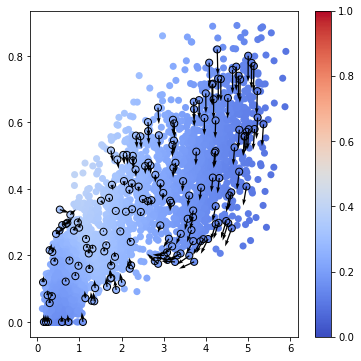

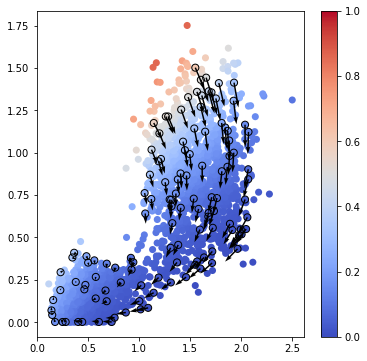

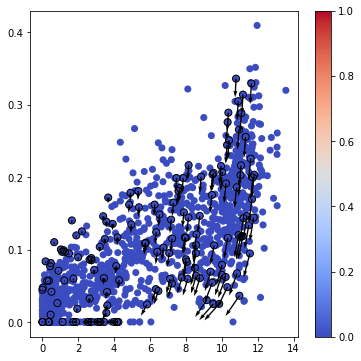

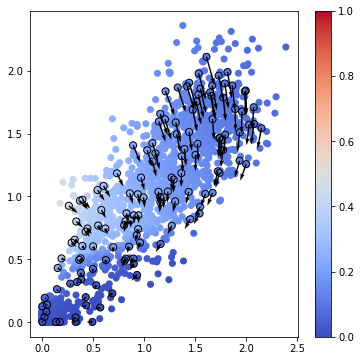

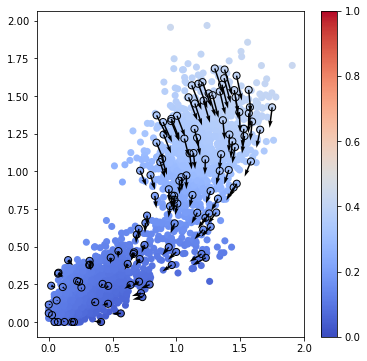

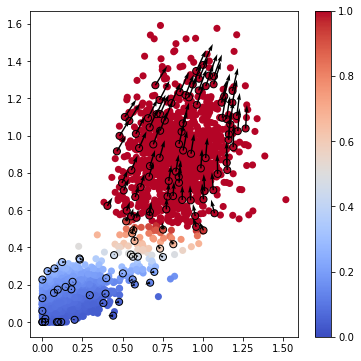

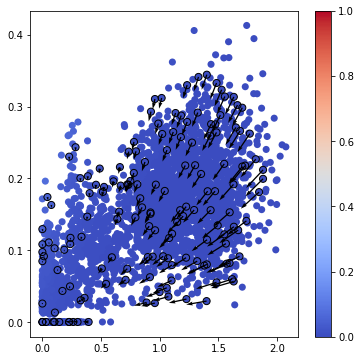

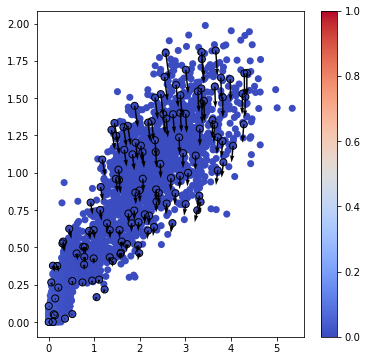

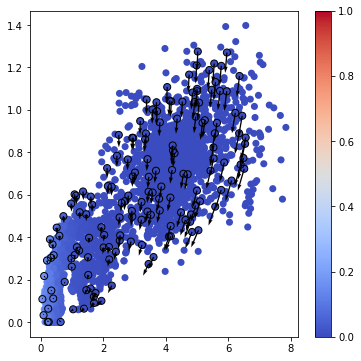

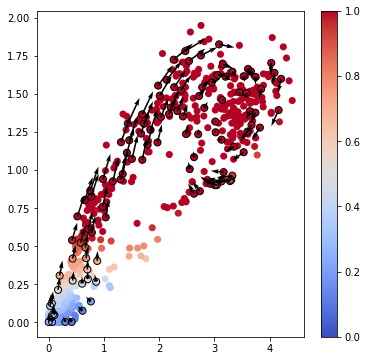

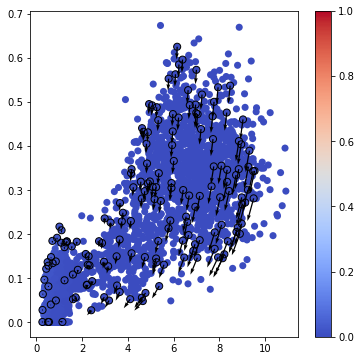

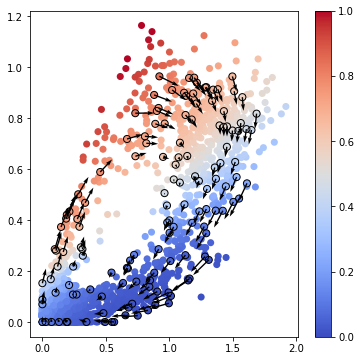

In [8]:

list_e=[500]
pointsize=120
pointsize=50
color_scatter="#95D9EF" #blue
alpha_inside=0.3

#color_scatter="#DAC9E7" #light purple
color_scatter="#8D71B3" #deep purple
alpha_inside=0.2
g_list=gene_plot_l_28

for e_num in list_e:
    file_path="output/detailcsv/adj_e/detail_e"+str(e_num)+".csv"
    detail = pd.read_csv (file_path,index_col=False)
    detail["alpha_new"]=detail["alpha"]/detail["beta"]
    detail["beta_new"]=detail["beta"]/detail["beta"]
    detail["gamma_new"]=detail["gamma"]/detail["beta"]
    detailfinfo="e"+str(e_num)

    #color_map="Spectral"
    #color_map="PiYG"
    #color_map="RdBu"
    color_map="coolwarm"
    # color_map="bwr"
    alpha_inside=0.3
    alpha_inside=1
    vmin=0
    vmax=1
    for i in g_list:
        save_path="output/velo_plot_adj_e/"+i+"_"+str(e_num)+".pdf"
        velocity_plot(detail, [i],detailfinfo,color_scatter,pointsize,alpha_inside,color_map,vmin,vmax,save_path) # from cell dancer


In [11]:

#### Box Plot for alpha_new, u0, s0 ####
def box_attribute(gene,log,ylim,ymin,ymax,att,save_path,detail):
    greyset=['grey']*8
    detail["alpha_new"]=detail["alpha"]/detail["beta"]
    detail["beta_new"]=detail["beta"]/detail["beta"]
    detail["gamma_new"]=detail["gamma"]/detail["beta"]
    g_list=set(detail["gene_name"])
    celllist_rep=pd.concat([adata.obs.clusters]*len(g_list), ignore_index=True) # match cell type
    detail = pd.concat([detail, celllist_rep], axis=1)

    boxlist=detail[detail.gene_name==gene]
    data=pd.DataFrame()
    for ct in cell_type:
        data=pd.concat([data,pd.DataFrame({'col':boxlist[boxlist.clusters==ct][att]})],axis=1,ignore_index=True)

    plt.figure()
    if ylim=="ylim":plt.ylim(ymin, ymax)
    if log=="log":data=np.log10(data)
    for i,d in enumerate(data):
        y = data[d]
        x = np.random.normal(i+1, 0.04, len(y))
        ax = plt.plot(x, y, mfc = greyset[i], mec='k', ms=3, marker="o", linestyle="None",alpha=0.2,markeredgewidth=0.0)
    data.boxplot(showfliers=False,grid=False,color=dict(boxes='black', whiskers='black', medians='black', caps='black')).set(title=gene)
    plt.savefig(save_path)
    return(data)

list_e=[500]
gene_plot_l=gene_plot_l_28
att="u0"
att="s0"
att="alpha_new"
cell_type=cell_type
#log="log";ylim="ylim"
ymin=-3;ymax=1
log="no";ylim="no"


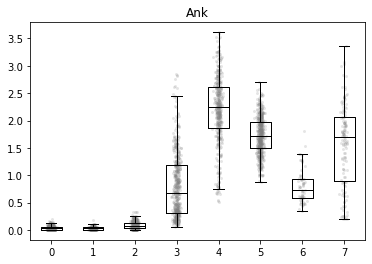

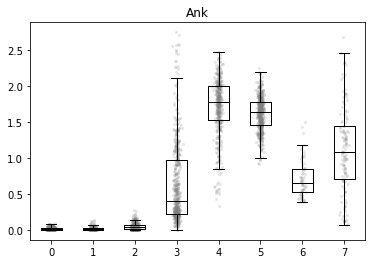

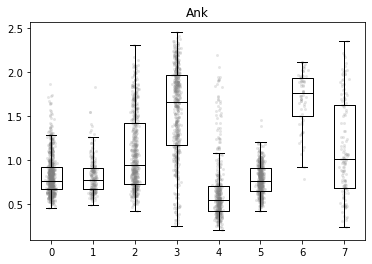

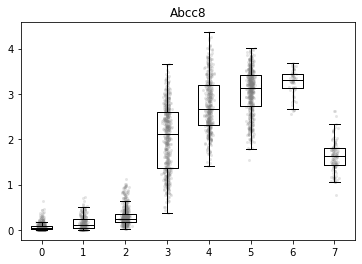

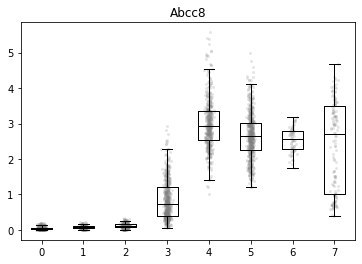

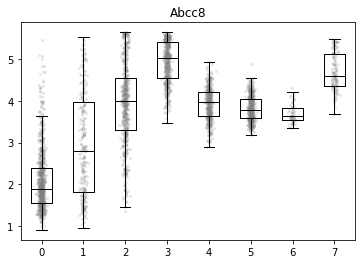

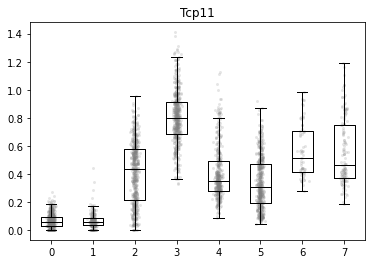

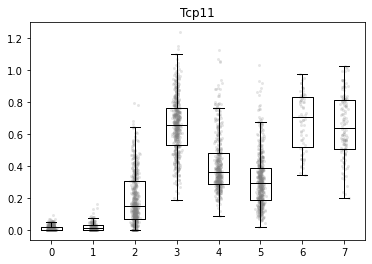

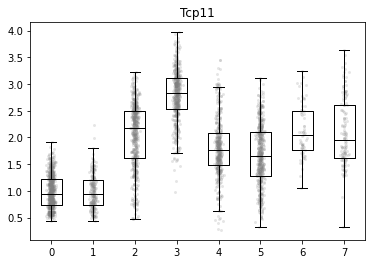

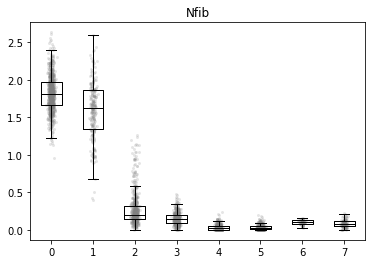

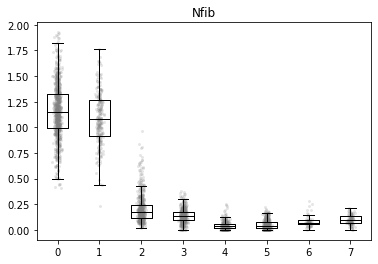

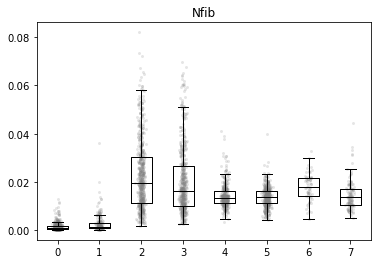

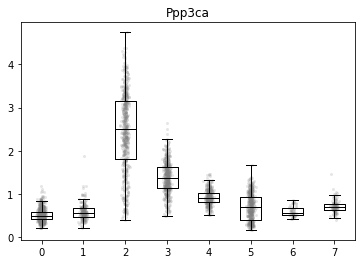

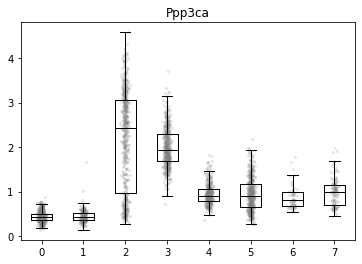

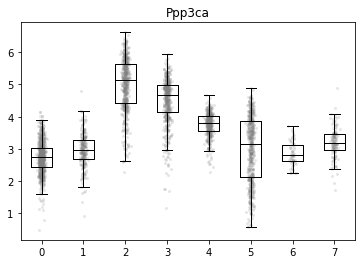

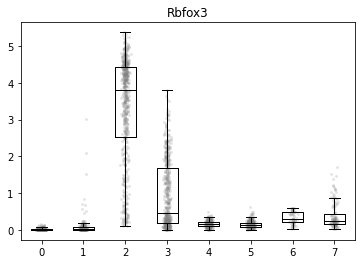

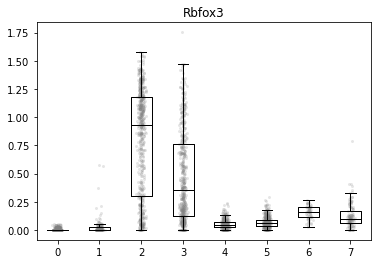

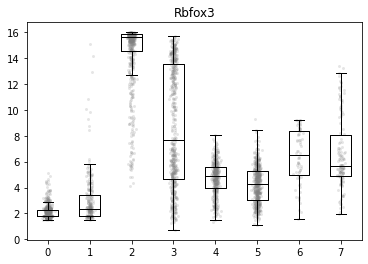

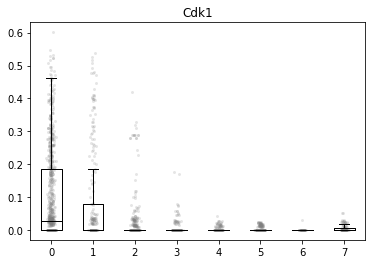

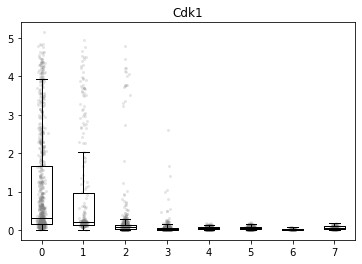

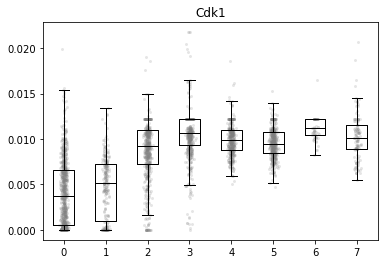

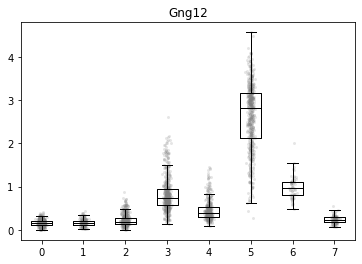

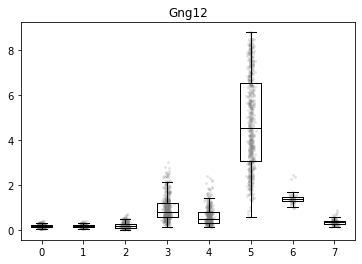

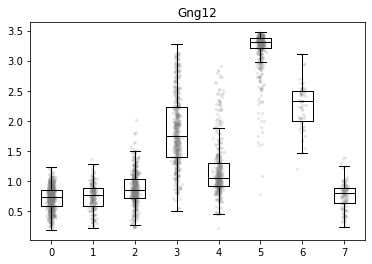

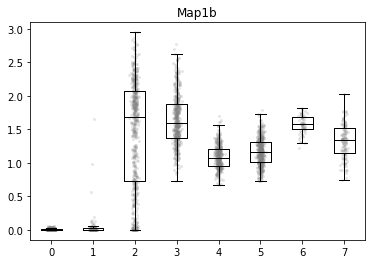

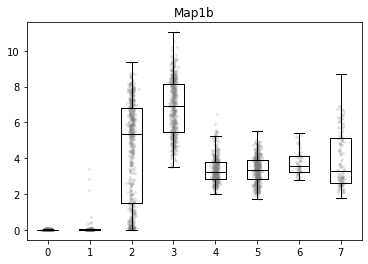

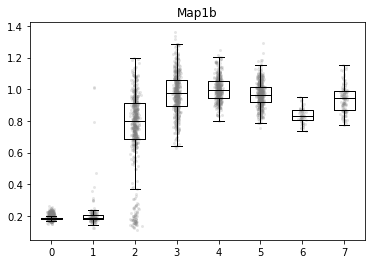

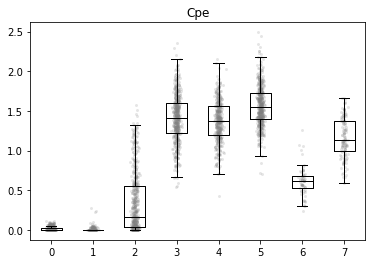

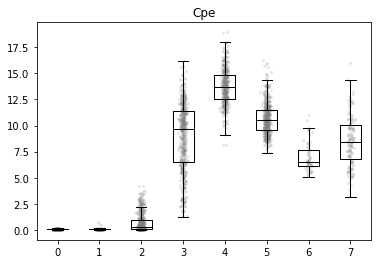

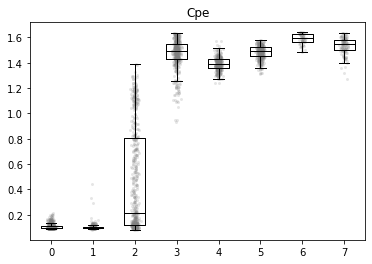

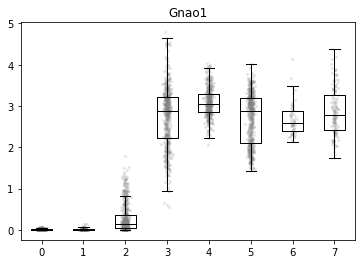

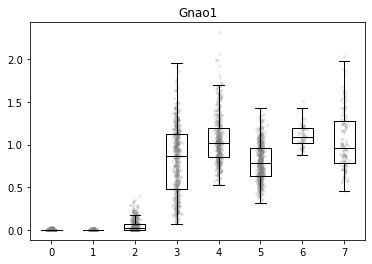

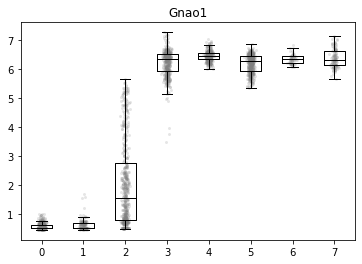

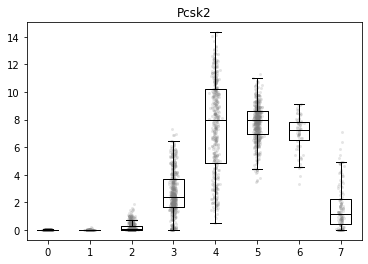

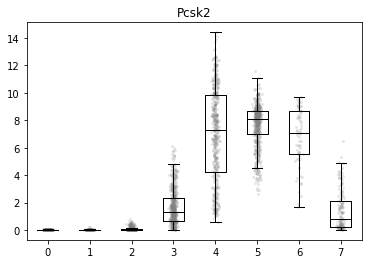

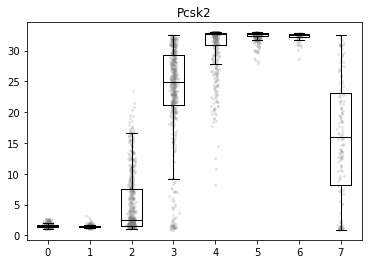

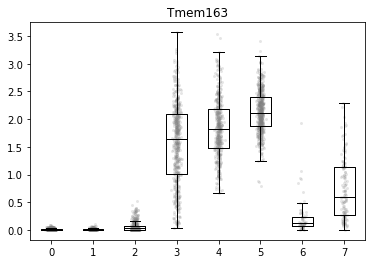

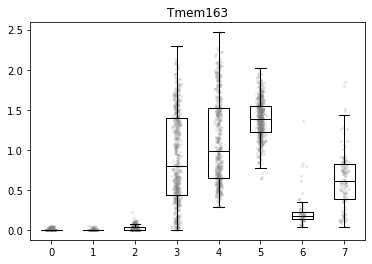

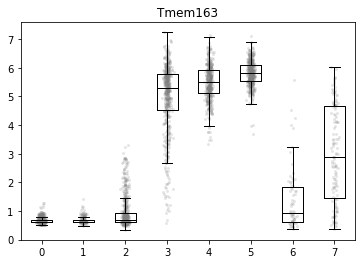

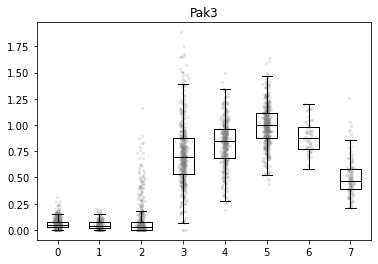

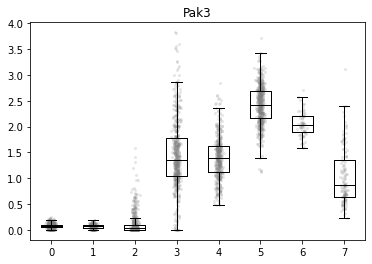

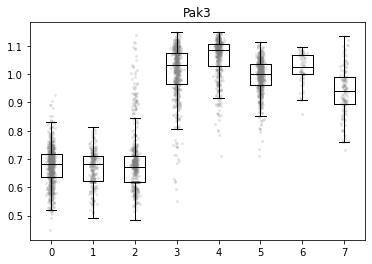

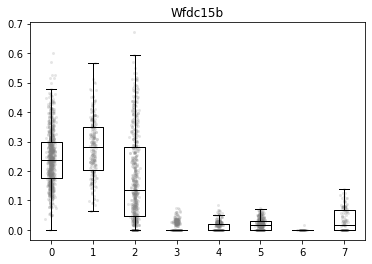

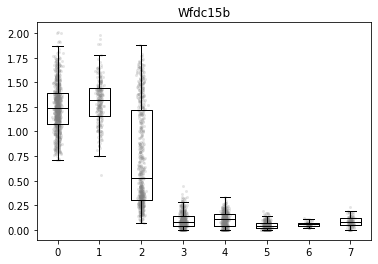

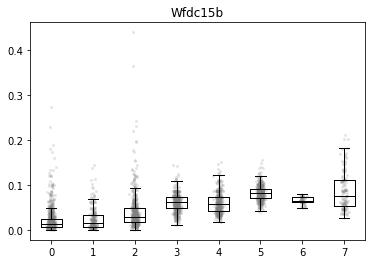

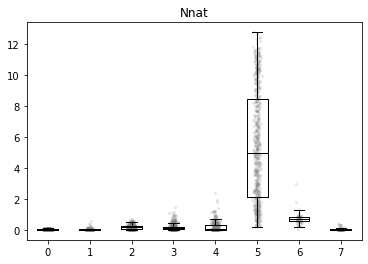

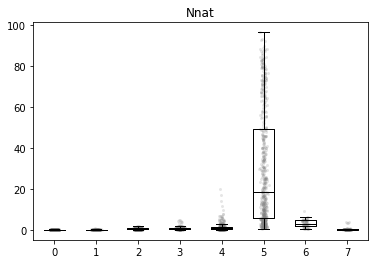

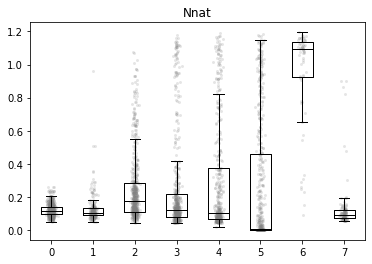

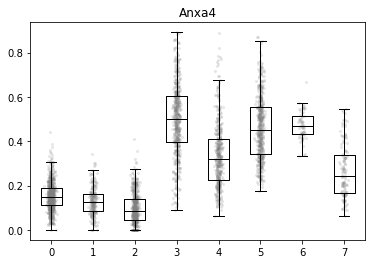

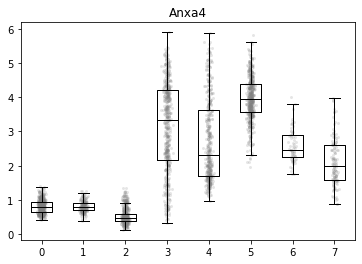

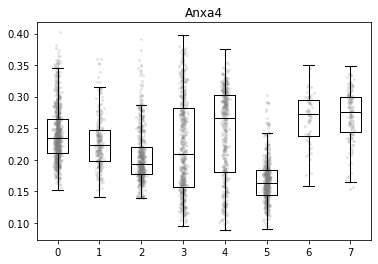

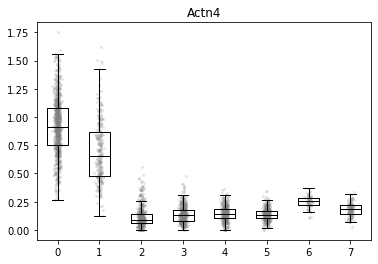

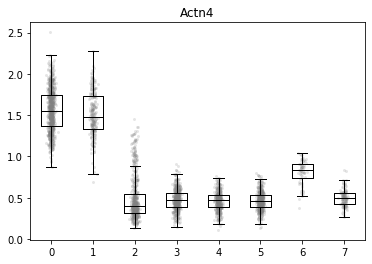

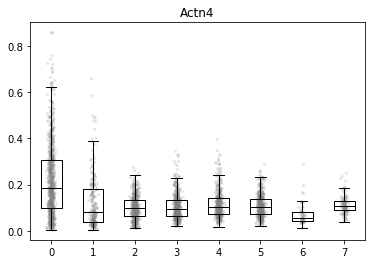

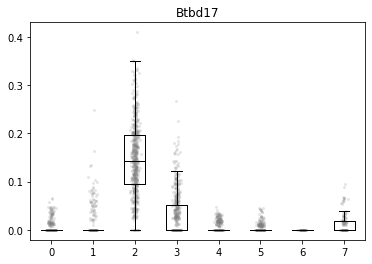

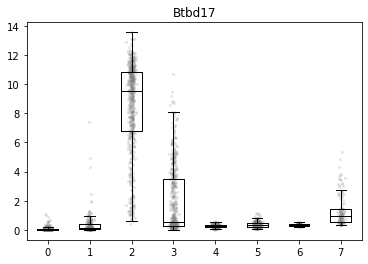

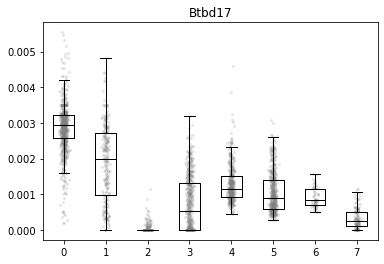

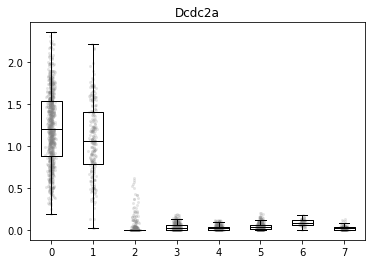

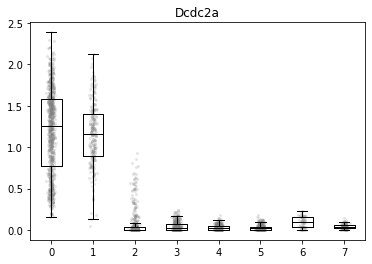

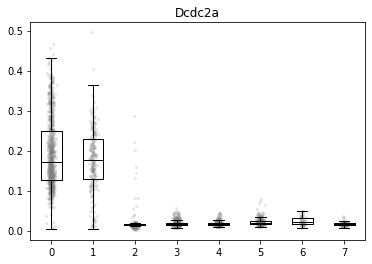

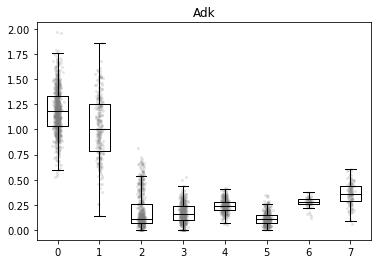

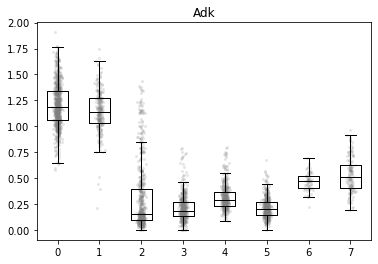

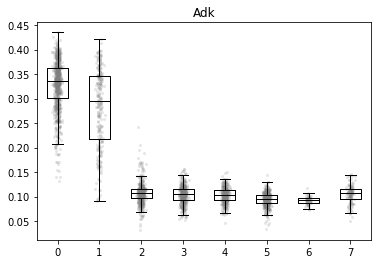

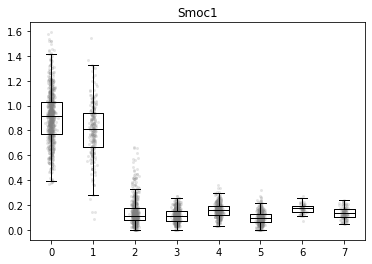

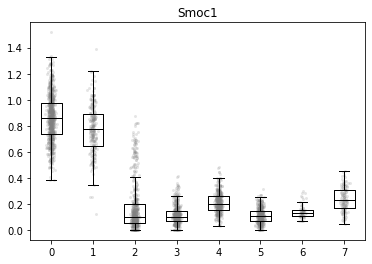

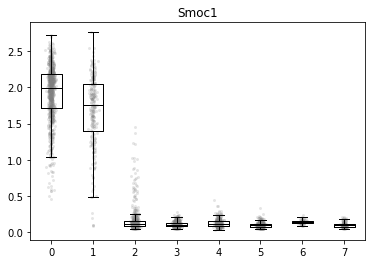

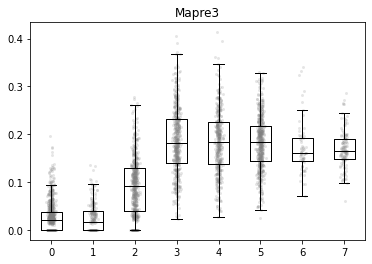

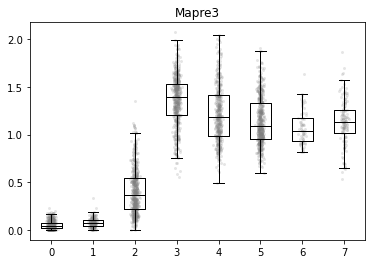

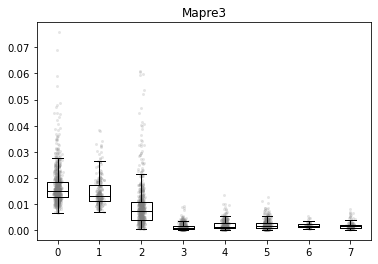

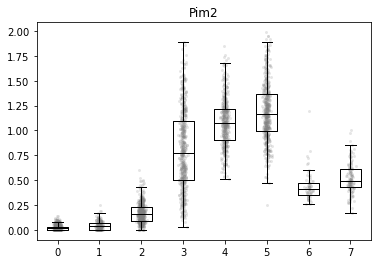

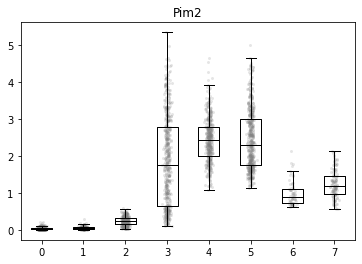

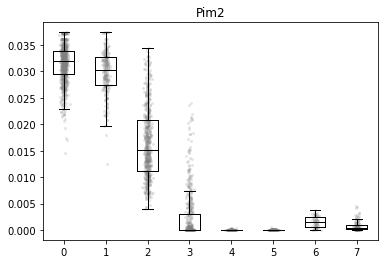

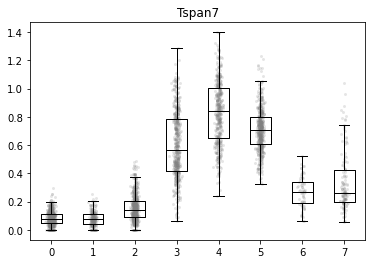

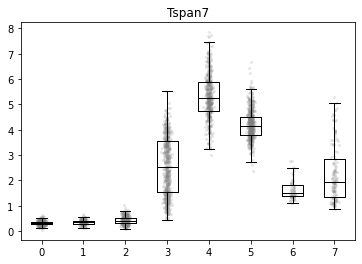

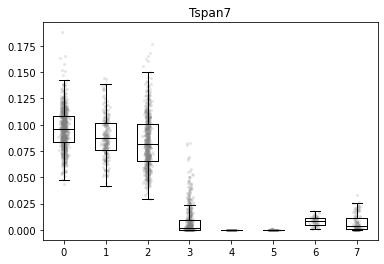

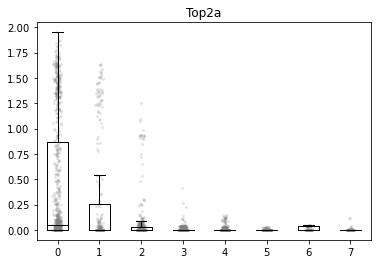

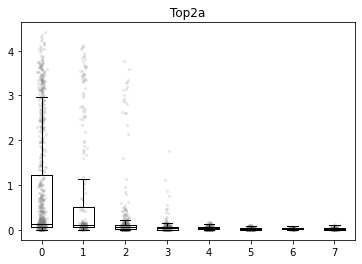

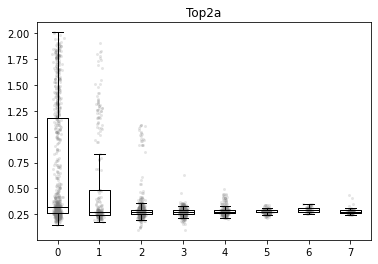

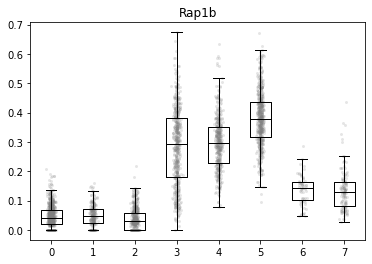

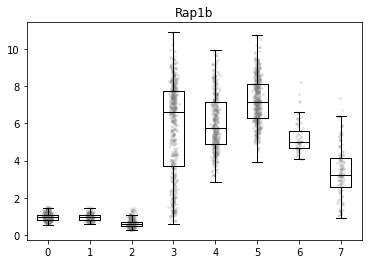

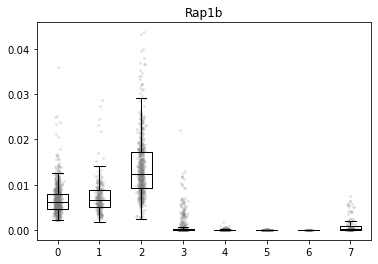

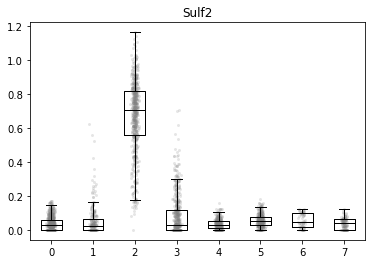

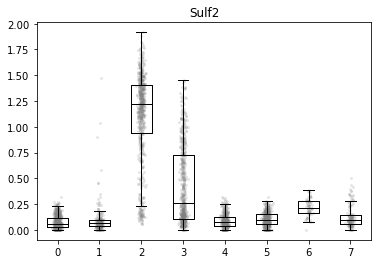

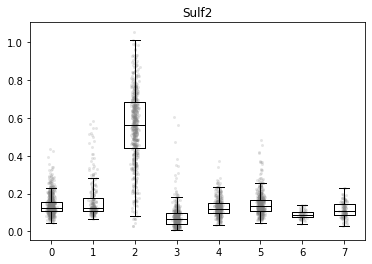

In [13]:
for e_num in list_e:
    for g in gene_plot_l:
        for att in ["u0","s0","alpha_new"]:
            save_path="output/dancer_plot_compare/box_"+att+"/velonn_"+g+".pdf"
            file_path="output/detailcsv/adj_e/detail_e"+str(e_num)+".csv"
            detail = pd.read_csv (file_path,index_col=False)
            data_att=box_attribute(g,log,ylim,ymin,ymax,att,save_path,detail)
            data_att.to_csv("output/dancer_plot_compare/box_"+att+"/data/velonn"+g+".csv",index=False)


<Figure size 324x216 with 0 Axes>

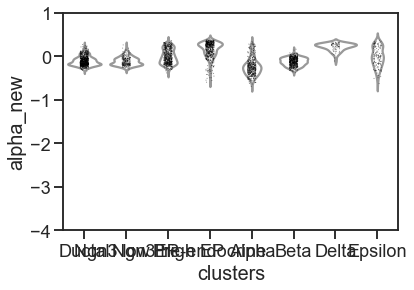

<Figure size 324x216 with 0 Axes>

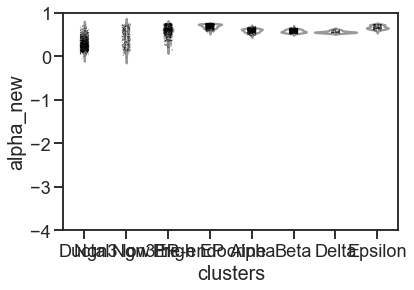

<Figure size 324x216 with 0 Axes>

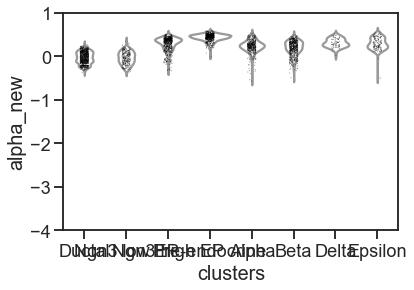

<Figure size 324x216 with 0 Axes>

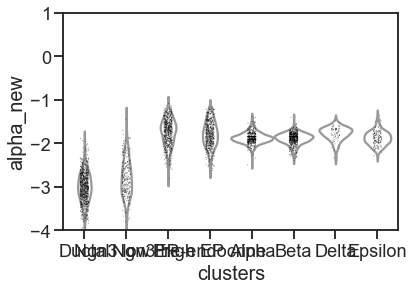

<Figure size 324x216 with 0 Axes>

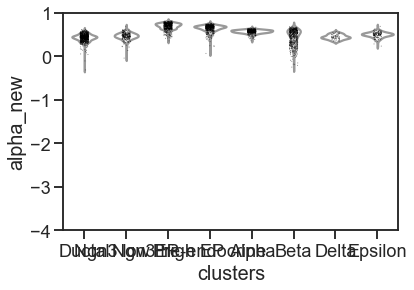

<Figure size 324x216 with 0 Axes>

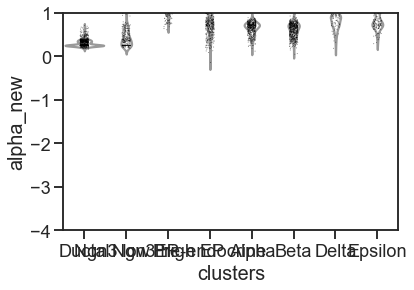

<Figure size 324x216 with 0 Axes>

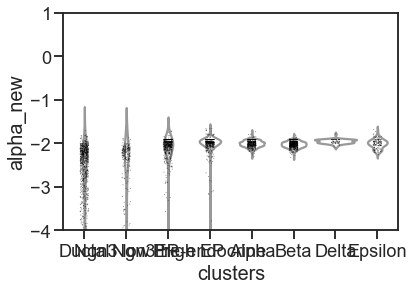

<Figure size 324x216 with 0 Axes>

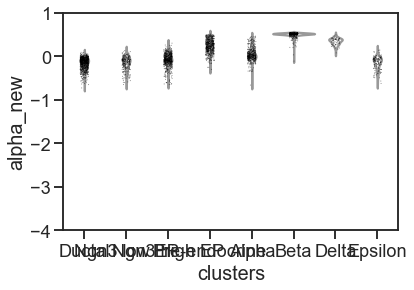

<Figure size 324x216 with 0 Axes>

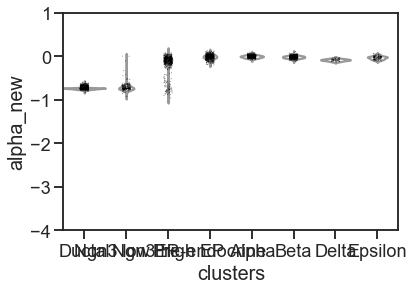

<Figure size 324x216 with 0 Axes>

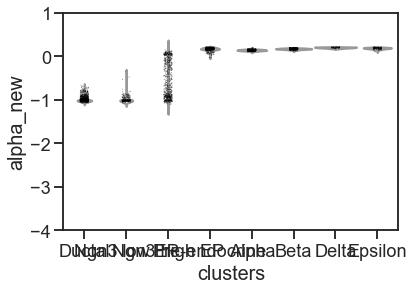

<Figure size 324x216 with 0 Axes>

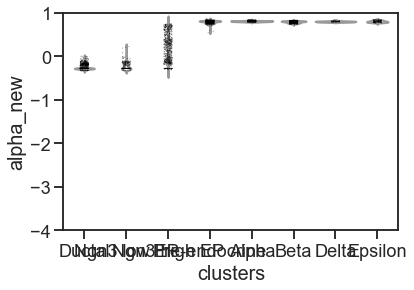

<Figure size 324x216 with 0 Axes>

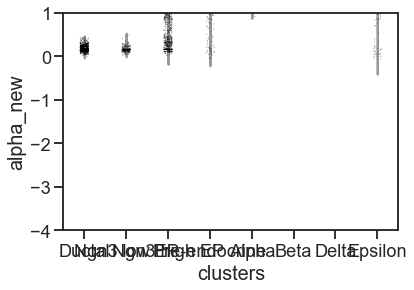

<Figure size 324x216 with 0 Axes>

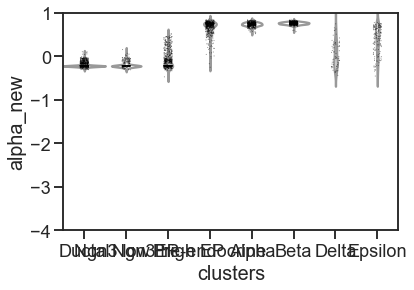

<Figure size 324x216 with 0 Axes>

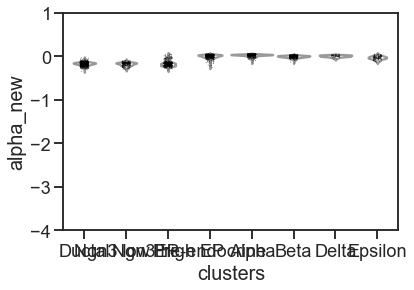

<Figure size 324x216 with 0 Axes>

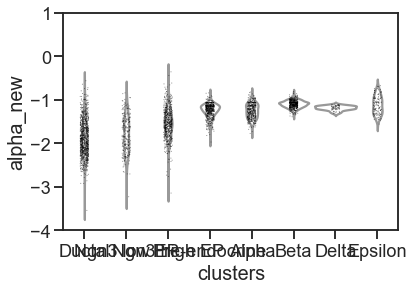

<Figure size 324x216 with 0 Axes>

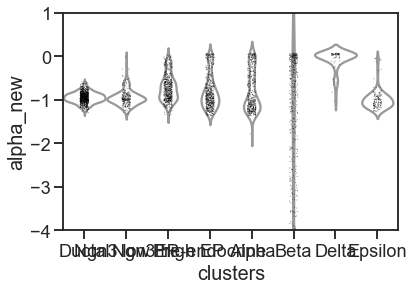

<Figure size 324x216 with 0 Axes>

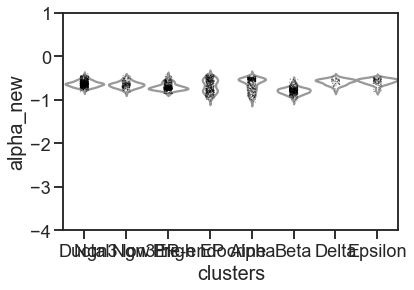

<Figure size 324x216 with 0 Axes>

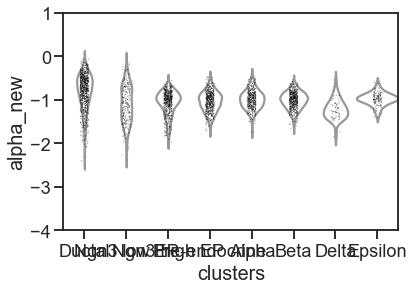

<Figure size 324x216 with 0 Axes>

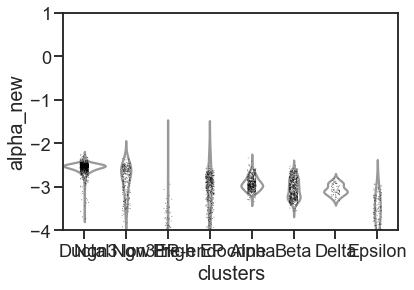

<Figure size 324x216 with 0 Axes>

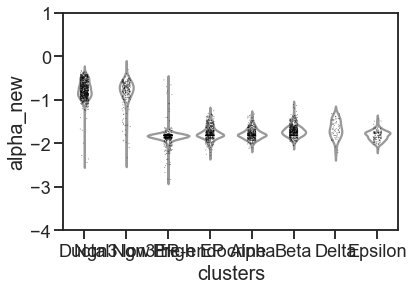

<Figure size 324x216 with 0 Axes>

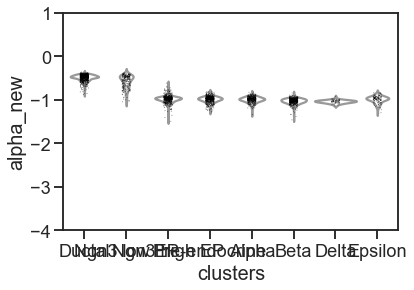

<Figure size 324x216 with 0 Axes>

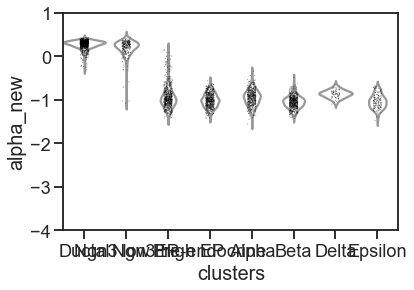

<Figure size 324x216 with 0 Axes>

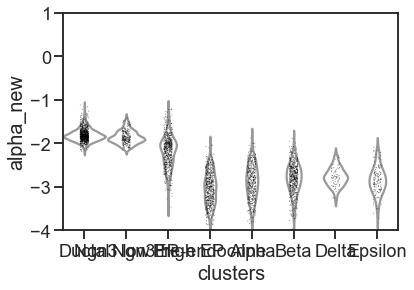

<Figure size 324x216 with 0 Axes>

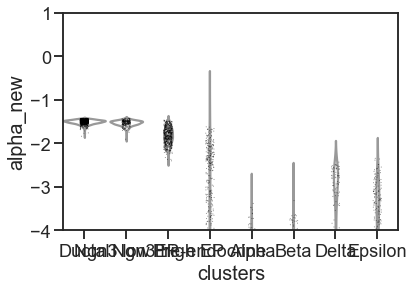

<Figure size 324x216 with 0 Axes>

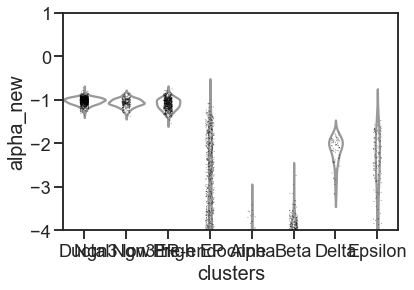

<Figure size 324x216 with 0 Axes>

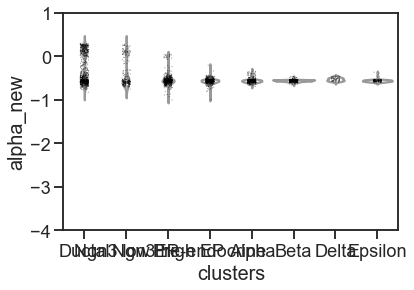

<Figure size 324x216 with 0 Axes>

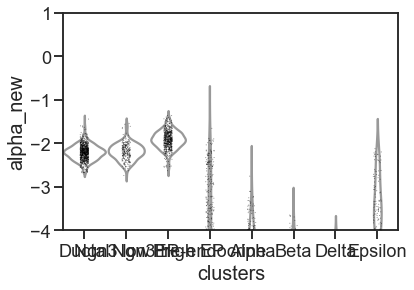

<Figure size 324x216 with 0 Axes>

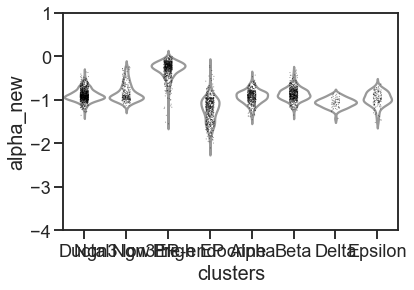

In [14]:

#### Violin Plot for alpha_new, u0, s0 ####
def violin_alpha(gene,log,ylim,ymin,ymax,save_path,detail):
    detail["alpha_new"]=detail["alpha"]/detail["beta"]
    detail["beta_new"]=detail["beta"]/detail["beta"]
    detail["gamma_new"]=detail["gamma"]/detail["beta"]
    g_list=set(detail["gene_name"])
    celllist_rep=pd.concat([adata.obs.clusters]*len(g_list), ignore_index=True)
    detail = pd.concat([detail, celllist_rep], axis=1)

    #### violin plot
    sns.set_style('white', {'axes.linewidth': 0.5})
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    sns.set_context("talk", font_scale=1.1)
    plt.figure(figsize=(4.5,3))
    plt.figure(figsize=(6,4))

    if ylim=="ylim":plt.ylim(ymin, ymax)#plt.ylim(-0.6, 2)
    v_data=detail[detail.gene_name==gene]
    np.random.seed(10) # set random seed
    if log=="log":v_data.alpha_new=np.log10(v_data.alpha_new)
    sns.stripplot(y="alpha_new", 
                x="clusters", 
                data=v_data,
            color="black", edgecolor="gray",s=1,alpha=0.5,order=cell_type)
    
    sns.violinplot(y="alpha_new", 
                x="clusters", 
                data=v_data,order=cell_type,color="white", width=1 ,inewidth=0.1, inner=None)
    plt.savefig(save_path)
    return(v_data)

e_num=[500]
gene_plot_l=gene_plot_l_28
log="log";ylim="ylim"
ymin=-4;ymax=1
#log="no";ylim="no"
for e_num in list_e:
    file_path="output/detailcsv/adj_e/detail_e"+str(e_num)+".csv"
    detail = pd.read_csv (file_path,index_col=False)
    for g in gene_plot_l:
        save_path="output/alpha_plot/violin/velonn_"+g+".pdf"
        data_violin=violin_alpha(g,log,ylim,ymin,ymax,save_path,detail)
        data_violin.to_csv("output/alpha_plot/violin/velonn_"+g+".csv",index=False)

